/Users/cofibration/Documents/Programming/low-prob-estimation/.venv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


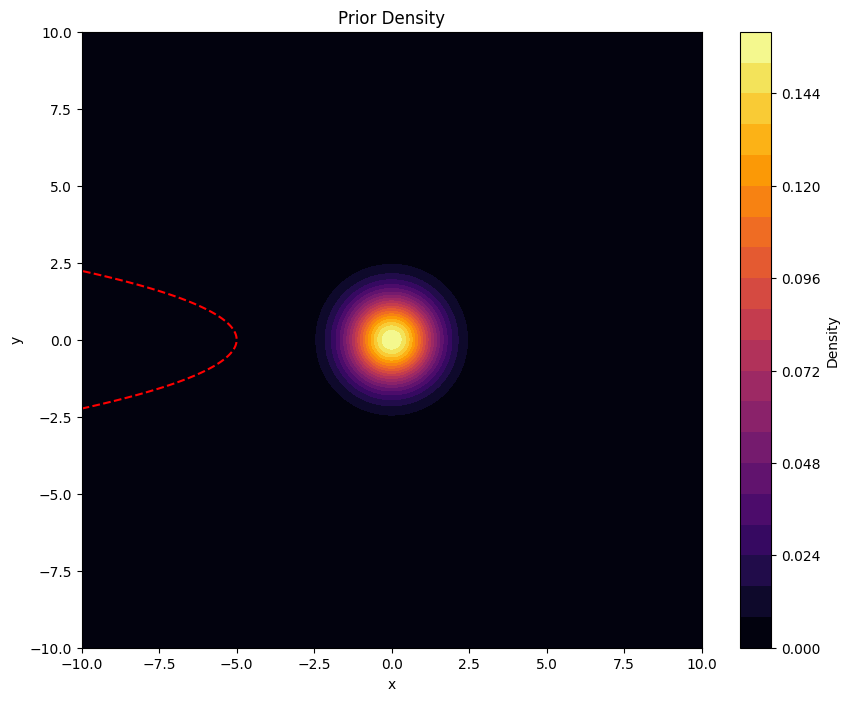

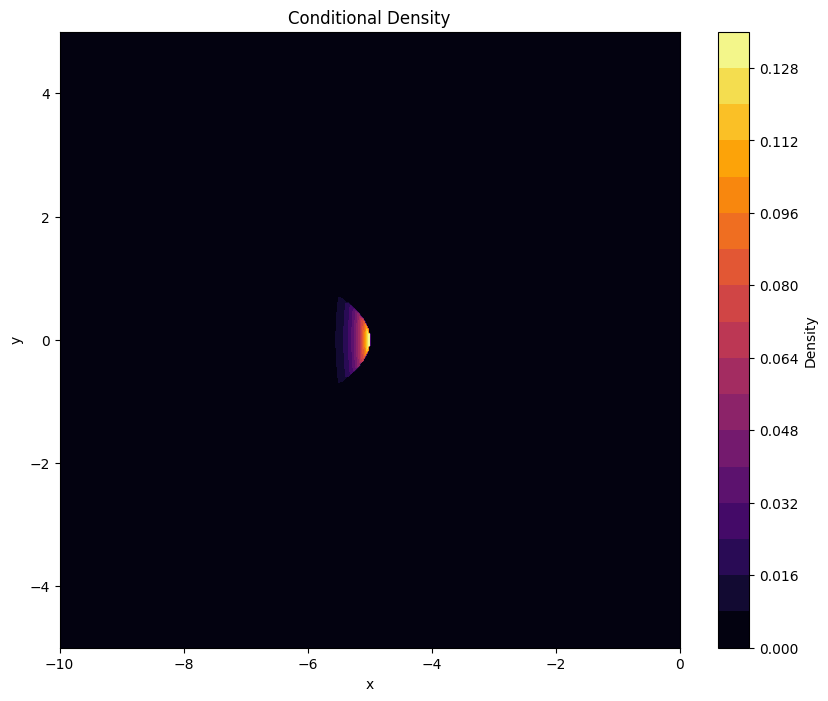

Integral of density: 0.996004
tensor(8.3464e-08)


In [1]:
# low-probability estimation using gaussians as the example distribution, and differentiable cost functions

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import tqdm

cost_threshold = -5

def cost_function(xs):
    return xs[:, 1].pow(2) + xs[:, 0]

def prior_density(xs):
    return torch.exp(-xs.pow(2).sum(dim=-1) / 2) / (2 * np.pi) ** (xs.shape[-1] / 2)

def log_prior_density(xs):
    return -xs.pow(2).sum(dim=-1) / 2

img_size = 500

full_lims = ((-10, 10), (-10, 10))
focus_lims = ((-10, 0), (-5, 5))

xs_full, ys_full = torch.meshgrid(torch.linspace(full_lims[0][0], full_lims[0][1], img_size), torch.linspace(full_lims[1][0], full_lims[0][1], img_size))
xs_focus, ys_focus = torch.meshgrid(torch.linspace(focus_lims[0][0], focus_lims[0][1], img_size), torch.linspace(focus_lims[1][0], focus_lims[1][1], img_size))

# plot density
points_full = torch.stack([xs_full, ys_full], dim=-1)

density_full = prior_density(points_full)

cost_full = cost_function(points_full.reshape(-1, 2)).reshape(points_full.shape[:-1])

plt.figure(figsize=(10, 8))
plt.contourf(xs_full.numpy(), ys_full.numpy(), density_full.numpy(), levels=20, cmap='inferno')
plt.colorbar(label='Density')
plt.contour(xs_full.numpy(), ys_full.numpy(), cost_full.numpy(), levels=[cost_threshold], colors='red')
plt.xlabel('x')
plt.ylabel('y') 
plt.title('Prior Density')
plt.show()

points_focus = torch.stack([xs_focus, ys_focus], dim=-1)
density_focus = prior_density(points_focus)
cost_focus = cost_function(points_focus.reshape(-1, 2)).reshape(points_focus.shape[:-1])

conditional_density_focus = density_focus.clone()
conditional_density_focus[cost_focus > cost_threshold] = 0
conditional_density_focus /= conditional_density_focus.sum() * (focus_lims[0][1] - focus_lims[0][0]) / img_size

plt.figure(figsize=(10, 8))
plt.contourf(xs_focus.numpy(), ys_focus.numpy(), conditional_density_focus.numpy(), levels=20, cmap='inferno')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y') 
plt.title('Conditional Density')
plt.show()

# check that the prior density integrates to 1
integral = density_full.sum() * (full_lims[0][1] - full_lims[0][0]) * (full_lims[1][1] - full_lims[1][0]) / (img_size * img_size)
print(f"Integral of density: {integral.item():.6f}")

conditional_density_full = density_full.clone()
conditional_density_full[cost_full > cost_threshold] = 0
normalizing_constant = conditional_density_full.sum() * (full_lims[0][1] - full_lims[0][0]) * (full_lims[1][1] - full_lims[1][0]) / (img_size * img_size)

print(normalizing_constant)

In [2]:
from dataclasses import dataclass

@dataclass
class SampleConfig:
    steps: int = 1_000
    start_lr: float = 0.1
    end_lr: float = 0.0001
    start_beta: float = 10
    end_beta: float = 100

def sample_langevin(particles, log_density, cost, threshold, config = SampleConfig()):
    def sample_step(xs, beta, step_size):
        xs.requires_grad_(True)
        scaled_cost = -torch.relu(beta * (cost(xs) - threshold))
        drift = torch.autograd.grad((log_density(xs) + scaled_cost).sum(), xs)[0]
        diffusion = torch.randn_like(xs)
        xs_new = xs.detach() + step_size * drift + np.sqrt(2 * step_size) * diffusion
        return xs_new

    xs = particles.clone()

    for i in range(config.steps):
        progress = i / config.steps
        beta = config.start_beta * (config.end_beta / config.start_beta) ** progress
        lr = config.start_lr * (config.end_lr / config.start_lr) ** progress
        xs = sample_step(xs, beta, lr)

    return xs

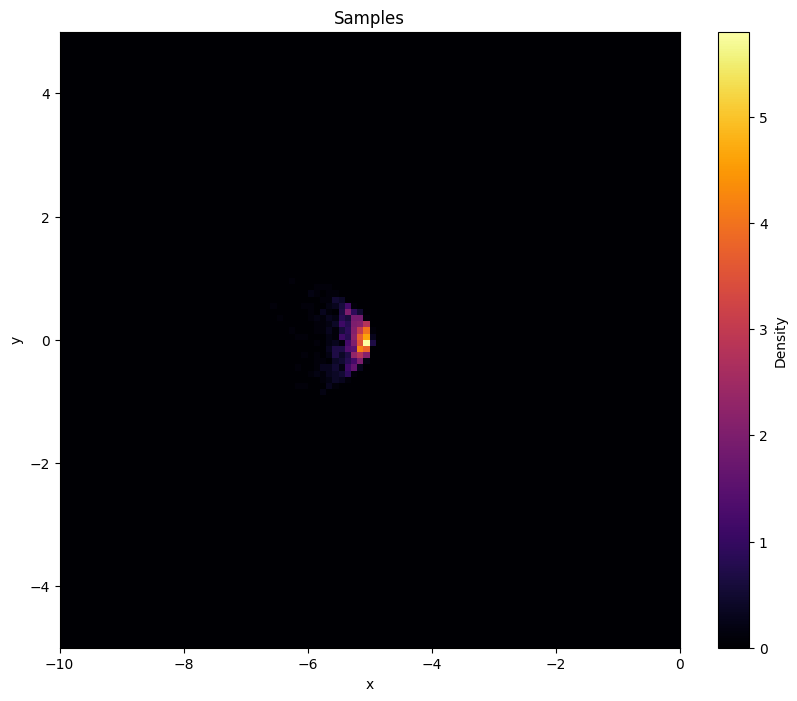

In [3]:
samples = sample_langevin(torch.randn(1_000, 2, dtype=torch.float64), log_prior_density, cost_function, cost_threshold)

plt.figure(figsize=(10, 8))
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=100, cmap='inferno', density=True, range=focus_lims)
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples')
plt.show()

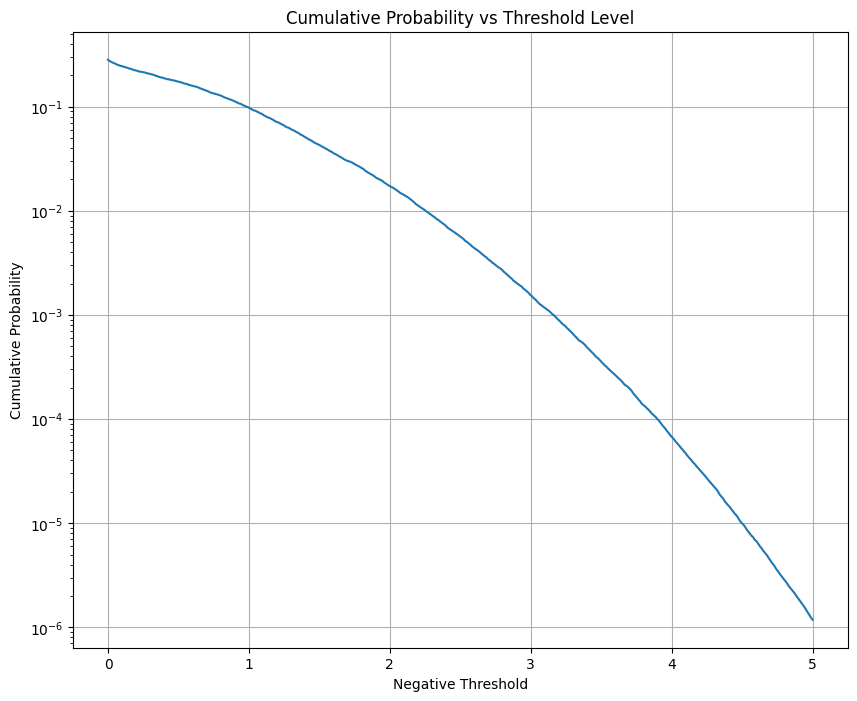

tensor(1.1830e-06)


In [4]:
def multilevel_estimation(start_particles, log_density, cost, levels, sample_config = SampleConfig()):
    threshold_probs = []
    particles = start_particles.clone()
    num_particles = len(particles)

    costs = cost(particles)

    for i in range(len(levels)):
        # calculate proportion of particles that are below the threshold
        below_threshold = (costs < levels[i]).float().mean()
        threshold_probs.append(below_threshold)
        # print(f'Threshold {levels[i]}: {below_threshold:.3f}')

        # resample particles
        replacement_particles = torch.cat([particles] * int(np.ceil(num_particles / len(particles))))
        particles = sample_langevin(replacement_particles[:num_particles], log_density, cost, levels[i], sample_config)

        costs = cost(particles)
        particles = particles[costs < levels[i]]
        costs = costs[costs < levels[i]]

    return torch.tensor(threshold_probs).prod(), threshold_probs

levels = np.linspace(0, -5, 500)

sample_config = SampleConfig(
    steps=100,
    start_lr=0.001,
    end_lr=0.00001,
    start_beta=100,
    end_beta=100
)

prob, threshold_probs = multilevel_estimation(torch.randn(1_000, 2, dtype=torch.float64), log_prior_density, cost_function, levels, sample_config)

plt.figure(figsize=(10, 8))
plt.plot(-levels, np.cumprod([p.item() for p in threshold_probs]))
plt.yscale('log')
plt.xlabel('Negative Threshold')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability vs Threshold Level')
plt.grid(True)
plt.show()

print(prob)